# Assignment 2: Convergence, Accounting, & Development

**GLBL 5010: Economics for Global Affairs**

**Group Members:**
* Kevin Chen
* Pranav Pattatathunaduvil
* Lucy Kim

---

# Data Cleaning

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

# Choosing country code for later question
MY_COUNTRY_CODE = "CAN"

# Load the data
df = pd.read_csv("hwk2_accounting.csv", sep="\t")

# Filter for rows that have data for both 1960 and 2018 to ensure consistent samples
df = df.dropna(subset=["pop1960", "cgdpo1960", "cn1960", "pop2018", "cgdpo2018", "cn2018"]).copy()

print("Number of countries after dropna:", len(df))
print(df.head())

Number of countries after dropna: 102
  countrycode    country    pop1960    hc1960  cgdpo1960      cn1960  \
3         ARG  Argentina  20.545674  1.953866    65001.0  107963.000   
5         AUS  Australia  10.470019  2.746758   163815.0  744405.700   
6         AUT    Austria   7.093828  2.403941    71811.0  176051.700   
7         BDI    Burundi   2.781159  1.095495     1920.0    5961.864   
8         BEL    Belgium   9.113383  2.307354    94903.0  493083.300   

     pop2018    hc2018  cgdpo2018      cn2018                     region  
3  44.361150  3.065968    1022236  3361087.00  Latin America & Caribbean  
5  24.898152  3.536047    1350340  5795477.00        East Asia & Pacific  
6   8.891388  3.369997     470542  2835065.00      Europe & Central Asia  
7  11.175374  1.402834       9048    18111.23         Sub-Saharan Africa  
8  11.482178  3.142735     510223  3436160.00      Europe & Central Asia  


---
# 1A

The production function is $Y=AK^{\alpha}L^{1-\alpha}$.

To express this in GDPPC, we simply divided by $L$

We"re also keeping in mind the lowercase variables ($y=Y/L$ and $k=K/L$)

$$\frac{Y}{L} = A \left(\frac{K}{L}\right)^\alpha \frac{L^{1-\alpha}}{L^{1-\alpha}}$$

$$y = A k^\alpha$$

--- 
# 1B

In [34]:
# Create GDPPC for 1960 and 2018
df["y_1960"] = df["cgdpo1960"] / df["pop1960"]
df["y_2018"] = df["cgdpo2018"] / df["pop2018"]

# Create log variables
df["ln_y_1960"] = np.log(df["y_1960"])
df["ln_y_2018"] = np.log(df["y_2018"])

# Calculate Annualized Growth Rate
# Formula: (ln(y_t) - ln(y_0)) / T
df["growth"] = (df["ln_y_2018"] - df["ln_y_1960"]) / 58

# Run OLS regression of annualized growth on initial log GDPPC (1960)
# Convergence Regression: growth_i = beta_0 + beta_1 * ln(y_1960) + error
class_regression = smf.ols("growth ~ ln_y_1960", data=df).fit()
print(class_regression.summary())

                            OLS Regression Results                            
Dep. Variable:                 growth   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.816
Date:                Mon, 26 Jan 2026   Prob (F-statistic):              0.181
Time:                        22:43:56   Log-Likelihood:                 282.16
No. Observations:                 102   AIC:                            -560.3
Df Residuals:                     100   BIC:                            -555.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0401      0.013      3.198      0.0


**Interpretation**

The coefficient on "ln_y_1960" is **-0.0021**.

While the coefficient is negative, which would typically suggest convergence (poorer countries growing faster), the p-value is **0.181**. 

Because this is >0.05, the result is **not statistically significant**, therefore we do not find strong evidence of convergence across this sample data of countries.

--- 
# 1C


In [35]:
# initialize alpha 
alpha = 0.30

# calculate k for both years
df["k_1960"] = df["cn1960"] / df["pop1960"]
df["k_2018"] = df["cn2018"] / df["pop2018"]

# log k
df["ln_k_1960"] = np.log(df["k_1960"])
df["ln_k_2018"] = np.log(df["k_2018"])

# calculate TFP (ln A)
# ln y = ln A + alpha * ln k  =>  ln A = ln y - alpha * ln k
df["ln_A_1960"] = df["ln_y_1960"] - alpha * df["ln_k_1960"]
df["ln_A_2018"] = df["ln_y_2018"] - alpha * df["ln_k_2018"]

# mean and std dev of ln A for 1960
print("1960 ln A Statistics:")
print(df["ln_A_1960"].describe()[["mean", "std"]])

1960 ln A Statistics:
mean    5.366537
std     0.620780
Name: ln_A_1960, dtype: float64


---
# 1D

Correlation between ln y and ln A (1960): 0.9406


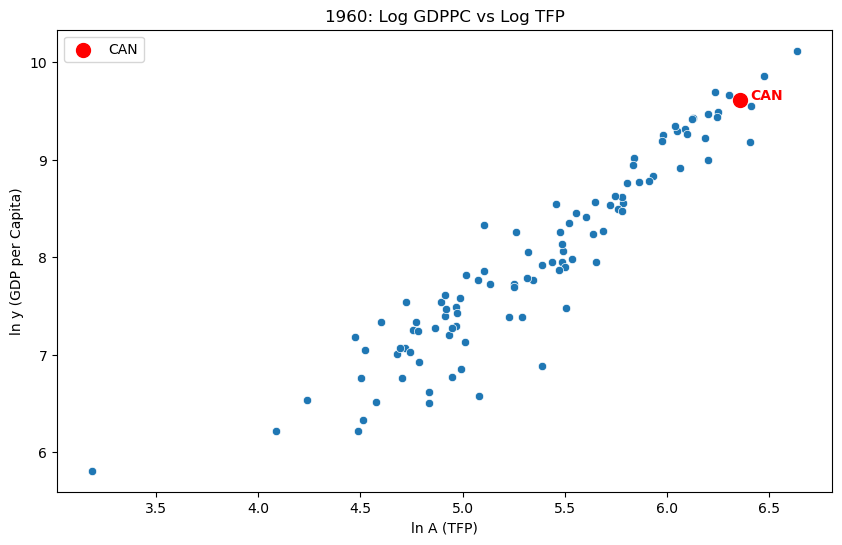

In [36]:
# correlation between ln y and ln A for 1960
corr_1d = df["ln_y_1960"].corr(df["ln_A_1960"])
print(f"Correlation between ln y and ln A (1960): {corr_1d:.4f}")

# scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(x="ln_A_1960", y="ln_y_1960", data=df)

# isolating the USA data point
my_data = df[df["countrycode"] == "CAN"]
if not my_data.empty:
    plt.scatter(my_data["ln_A_1960"], my_data["ln_y_1960"], color="red", s=100, label=MY_COUNTRY_CODE)
    plt.text(my_data["ln_A_1960"].values[0]+0.05, my_data["ln_y_1960"].values[0], MY_COUNTRY_CODE, color="red", weight="bold")

plt.title("1960: Log GDPPC vs Log TFP")
plt.xlabel("ln A (TFP)")
plt.ylabel("ln y (GDP per Capita)")
plt.legend()
plt.show()

The correlation for Canada is **~0.94**.

Canada is located in the top right upper cluster which indicates **high TFP and high income**.

In [37]:
# calculate US TFP for 2018
us_tfp_2018 = df.loc[df["countrycode"] == "USA", "ln_A_2018"].values[0]
print(f"USA TFP (2018): {us_tfp_2018:.4f}")

# isolate ln y for 2018 using US TFP
df["ln_y_2018_hyp"] = us_tfp_2018 + alpha * df["ln_k_2018"]

# Canada for our example and isolating based on country code
target_country = "CAN"

hyp_ln_y = df.loc[df["countrycode"] == target_country, "ln_y_2018_hyp"].values[0]
hyp_gdp_val = np.exp(hyp_ln_y)
actual_ln_y_1960 = df.loc[df["countrycode"] == target_country, "ln_y_1960"].values[0]

# calculate hypothetical growth variable
hyp_growth = hyp_ln_y - actual_ln_y_1960

# printing stats
print(f"--- {target_country} Hypothetical Results ---")
print(f"Hypothetical ln y (2018): {hyp_ln_y:.4f}")
print(f"Hypothetical GDP per capita (2018): ${hyp_gdp_val:,.2f}")
print(f"Hypothetical Growth (1960-2018): {hyp_growth:.4f}")

USA TFP (2018): 7.3540
--- CAN Hypothetical Results ---
Hypothetical ln y (2018): 11.0587
Hypothetical GDP per capita (2018): $63,493.33
Hypothetical Growth (1960-2018): 1.4441


**Answer:**
If Canada had US-level TFP in 2018:
* Hypothetical log GDP: **~11.06**
* Hypothetical GDP ($): **$63,493.33**
* Hypothetical Growth: **~1.44**

---
# 1F

In [38]:
# calculate hypothetical growth for all countries with 2018 and 1960 data
df["growth_hyp"] = df["ln_y_2018_hyp"] - df["ln_y_1960"]

# run Regression of differences
reg_1f = smf.ols("growth_hyp ~ ln_y_1960", data=df).fit()
print(reg_1f.summary())

                            OLS Regression Results                            
Dep. Variable:             growth_hyp   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     437.6
Date:                Mon, 26 Jan 2026   Prob (F-statistic):           2.64e-38
Time:                        22:43:56   Log-Likelihood:                -27.428
No. Observations:                 102   AIC:                             58.86
Df Residuals:                     100   BIC:                             64.11
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.9687      0.261     30.581      0.0

**Interpretation:**

The new coefficient on "ln_y_1960" is **-0.6763**.

Comparing this to the result in 1B (which was -0.1214 and not significant), this new coefficient is **much more negative and highly statistically significant**.

This implies that if all countries had the same level of TFP (specifically, the US level), there would be **very strong unconditional convergence**. The fact that we don't see this convergence in reality implies that **TFP differences** are the primary reason why poorer countries are not catching up to richer ones.

---

# 2A

It is reasonable to include human capital because labor is not homogeneous. Workers with more education or skills are more productive in a country's workforce. Ignoring this variable essentially hides it inside TFP, making the measure of technology and efficiency with these skills less accurate.

---

# 2B

In [39]:
import pandas as pd
import numpy as np

# Load the data (assuming tab-separated based on the file structure)
df = pd.read_csv('hwk2_accounting.csv', sep='\t')

# Calculate Per Capita values for 2018
df["y_2018"] = df["cgdpo2018"] / df["pop2018"]
df["k_2018"] = df["cn2018"] / df["pop2018"]

# ake Natural Logs
df["ln_y_2018"] = np.log(df["y_2018"])
df["ln_k_2018"] = np.log(df["k_2018"])
df["ln_H_2018"] = np.log(df["hc2018"])

# Calculate TFP (A) with Human Capital
# Production Function: y = A * k^0.3 * H^0.7
df["ln_A_hc_2018"] = df["ln_y_2018"] - 0.3 * df["ln_k_2018"] - 0.7 * df["ln_H_2018"]

# Display stats
print("2018 ln A (with Human Capital) Statistics:")
print(df["ln_A_hc_2018"].describe()[["mean", "std"]])
print(f"\nTotal countries included: {df['ln_A_hc_2018'].count()}")

2018 ln A (with Human Capital) Statistics:
mean    5.534659
std     0.644604
Name: ln_A_hc_2018, dtype: float64

Total countries included: 142


---

# 2C

Correlation (2018) ln y vs ln A_hc: 0.9612


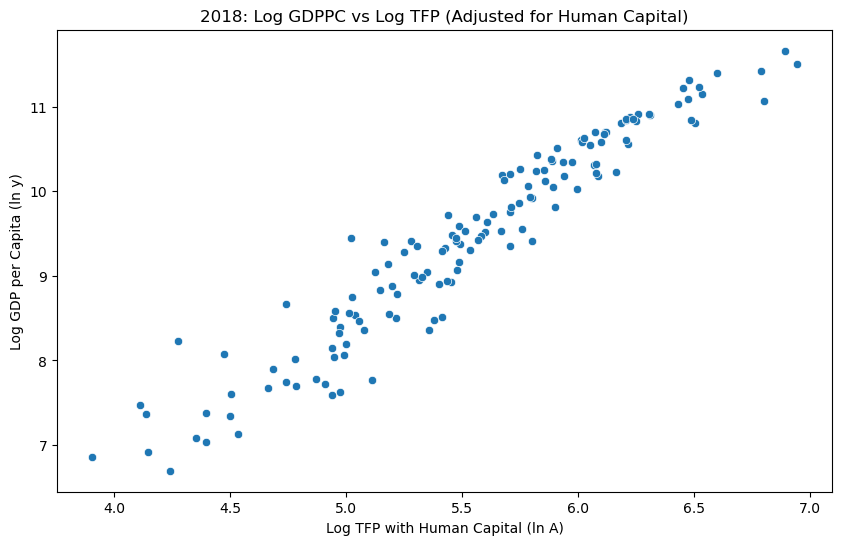

In [40]:
# Correlation
corr_2c = df["ln_y_2018"].corr(df["ln_A_hc_2018"])
print(f"Correlation (2018) ln y vs ln A_hc: {corr_2c:.4f}")

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x="ln_A_hc_2018", y="ln_y_2018", data=df)
plt.title("2018: Log GDPPC vs Log TFP (Adjusted for Human Capital)")
plt.xlabel("Log TFP with Human Capital (ln A)")
plt.ylabel("Log GDP per Capita (ln y)")
plt.show()


**Interpretation:**

The correlation is **0.9612**.

This correlation differs from the one in Question 1 because we have now explicitly included **Human Capital (education)** in the production function.

In Question 1, the "TFP" term captured everything we couldn't explain when it comes to human capital. Like how workers in rich countries are often more educated. By adding Human Capital ($H$) as an input, we have extracted that variation from the residual. The remaining TFP now represents a more accurate measure of efficiency and technology, separate from physical labor quality.

---

# 2D

Correlation between Simple TFP and Human Capital TFP: 0.9821


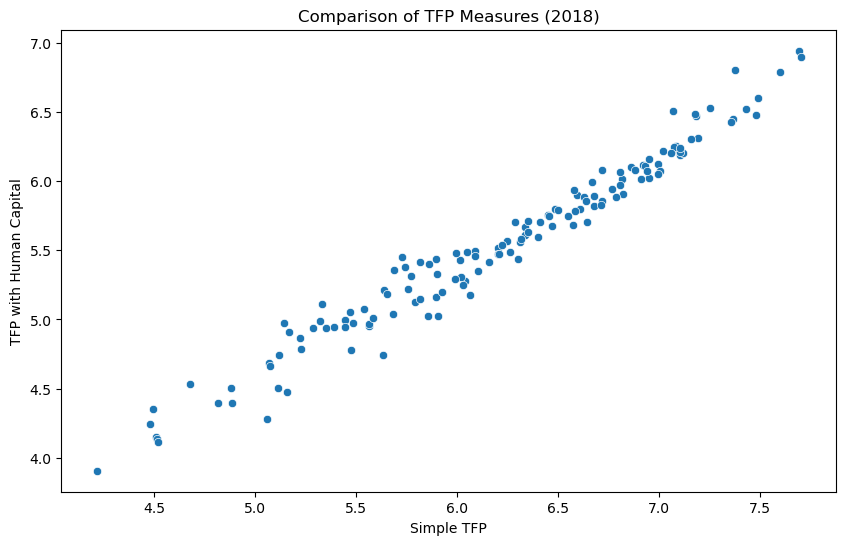

In [41]:
# Calculate Simple TFP (ln_A_2018)
# Formula: ln A = ln y - 0.3 * ln k
df["ln_A_2018"] = df["ln_y_2018"] - 0.3 * df["ln_k_2018"]

# correlation between old TFP (ln_A_2018) and new TFP (ln_A_hc_2018)
corr_2d = df["ln_A_2018"].corr(df["ln_A_hc_2018"])
print(f"Correlation between Simple TFP and Human Capital TFP: {corr_2d:.4f}")

plt.figure(figsize=(10, 6))
sns.scatterplot(x="ln_A_2018", y="ln_A_hc_2018", data=df)
plt.title("Comparison of TFP Measures (2018)")
plt.xlabel("Simple TFP")
plt.ylabel("TFP with Human Capital")
plt.show()

---

# 2E

**Question 2E:**

**Explanation:**
TFP is a "measure of our ignorance" because it captures everything that affects output *other* than the inputs we explicitly measure (Capital and Labor). By adding Human Capital to the production function, we are explicitly measuring an input that was previously just captured in bulk in the residual TFP variable. This now reduces ignoratnce as we can now explain more of the GDP differences using observable data like education levels.

**Revision:**
Based on 1F, we might have focused purely on "efficiency" reforms. However, the augmented model shows that low human capital is also a constraint. Therefore, budget allocations should not just focus on TFP-enhancing reforms but also significantly on human capital reforms like health or education to drive development.